In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pylab 
import random
import requests
import scipy.stats as stats
import seaborn as sb
import time
from xml.etree import ElementTree as ET

## Code to pull boardgame info

In [3]:
# Creating a function to get the boardgame data from each page

def boardgame_info(tree):
    
    id_num = int(tree[0].attrib['id'])
    boardgamecategory = []
    boardgamemechanic = []
    boardgamedesigner = []
    
    for i in range(len(tree[0])):
        
        if tree[0][i].tag == 'name':
            if tree[0][i].attrib['type'] == 'primary':
                boardgame_name = tree[0][i].attrib['value']
                
        elif tree[0][i].tag == 'yearpublished':
            year_publ = int(tree[0][i].attrib['value'])
            
        elif tree[0][i].tag == 'minplayers':
            minplayers = int(tree[0][i].attrib['value'])
            
        elif tree[0][i].tag == 'maxplayers':
            maxplayers = int(tree[0][i].attrib['value'])   
            
        elif tree[0][i].tag == 'playingtime':
            playingtime = int(tree[0][i].attrib['value']) 
            
        elif tree[0][i].tag == 'minplaytime':
            minplaytime = int(tree[0][i].attrib['value']) 
            
        elif tree[0][i].tag == 'maxplaytime':
            maxplaytime = int(tree[0][i].attrib['value'])
            
        elif tree[0][i].tag == 'link':
            
            if tree[0][i].attrib['type'] == 'boardgamecategory':
                boardgamecategory.append(tree[0][i].attrib['value'])
                
            elif tree[0][i].attrib['type'] == 'boardgamemechanic':
                boardgamemechanic.append(tree[0][i].attrib['value'])
                
            elif tree[0][i].attrib['type'] == 'boardgamedesigner':
                boardgamedesigner.append(tree[0][i].attrib['value'])
     
    keys = ['game ID#', 'boardgame', 'year published', 'min players', 'max players', 'playing time', 'min playing time', 'max playing time', 'category', 'boardgame mechanic', 'boardgamedesigner']
    values = [id_num, boardgame_name, year_publ, minplayers, maxplayers, playingtime, minplaytime, maxplaytime, boardgamecategory, boardgamemechanic, boardgamedesigner]
    dictionary = dict(zip(keys, values))

    return dictionary           

## Code to pull boardgame ratings

In [5]:
# Lines of code used for checking code:

# ratings_response = requests.get('https://www.boardgamegeek.com/xmlapi2/thing?id=13&ratingcomments=1&page=1')
# ratings_tree = ET.fromstring(ratings_response.content)

In [4]:
# Creating a function to get the boardgame ratings

def get_ratings_per_page(ratings_tree):
        
    # Figuring out the number of ratings pages
    for i in range(len(ratings_tree[0])):
        if ratings_tree[0][i].tag == 'comments':
            ratings_info = i
            num_ratings = float(ratings_tree[0][i].attrib['totalitems'])
    #print(ratings_info)

    all_local_ratings = []
    for i in range(len(ratings_tree[0][ratings_info])):

        username = ratings_tree[0][ratings_info][i].attrib['username']
        rating = float(ratings_tree[0][ratings_info][i].attrib['rating'])     

        ratings_keys = ['username', 'rating']
        ratings_values = [username, rating]
        ratings_dictionary = dict(zip(ratings_keys, ratings_values))
        
        all_local_ratings.append(ratings_dictionary)
        
        #print(ratings_dictionary)
    return all_local_ratings

In [6]:
def get_all_ratings(ID):
    
    site = 'https://www.boardgamegeek.com/xmlapi2/thing?id='
    page_num = ID   
    ratings_site = '&ratingcomments=1&page='
    ratings_page_num_1 = 1
       
    ratings_website = site + str(page_num) + ratings_site + str(ratings_page_num_1)
    ratings_response = requests.get(ratings_website)
    ratings_tree = ET.fromstring(ratings_response.content)
        
   
    # Figuring out the number of ratings pages
    num_ratings = 0
    for j in range(len(ratings_tree[0])):
        if ratings_tree[0][j].tag == 'comments':
            num_ratings = float(ratings_tree[0][j].attrib['totalitems'])
    #print(num_ratings)
    
    num_pages = round(num_ratings/100)
    if num_pages < num_ratings/100:
        num_pages += 1
    #print(num_pages)

    all_ratings = []
    for k in range(num_pages):
        ratings_website2 = site + str(page_num) + ratings_site + str(k+1)
        ratings_response2 = requests.get(ratings_website2)
        ratings_tree2 = ET.fromstring(ratings_response2.content)
        #print(k, ratings_website2)
        all_ratings.append(get_ratings_per_page(ratings_tree2))
        time.sleep(2)        
    return all_ratings

## Pulling all info and ratings of multiple games

In [7]:
def get_all_game_info(ID):
    
    # boardgame websites
    site = 'https://www.boardgamegeek.com/xmlapi2/thing?id='
    page_num = ID
    website = site+str(page_num)        
    response = requests.get(website)
    tree = ET.fromstring(response.content)
       
    ratings_site = '&ratingcomments=1&page='
    ratings_page_num_1 = 1
       
    ratings_website = site + str(page_num) + ratings_site + str(ratings_page_num_1)
    ratings_response = requests.get(ratings_website)
    ratings_tree = ET.fromstring(ratings_response.content) 

    bg_info = boardgame_info(tree)
    bg_ratings = get_all_ratings(ID)
    bg_info['ratings'] = bg_ratings
    time.sleep(5)         

    
    return bg_info

## Pulling all info from BoardGameGeek's API

In [ ]:
for ID in range(1,50001):
    site = 'https://www.boardgamegeek.com/xmlapi2/thing?id='
    page_num = ID
    website = site+str(page_num)        
    response = requests.get(website)
    tree = ET.fromstring(response.content)

    if len(tree) > 0 and tree[0].attrib['type'] == 'boardgame':
        ind_bg = get_all_game_info(ID)
        #print(ID)
        with open('ind_bg_{0}.json'.format(ID), 'w') as json_file:
            json.dump(ind_bg, json_file)
    
    time.sleep(5)

In [27]:
# updating the path
path = 'C:/Users/Ariel/Desktop/BGG_JSON_files/'
os.chdir(path)

# Loop through all the json files in the forlder
ind_bg = []
for i in range(1,49984):
    
    if os.path.exists('ind_bg_{0}.json'.format(i)) == True:
        
        #open the file
        with open('ind_bg_{0}.json'.format(i)) as f:
          ind_bg_json = json.load(f)
        #ind_bg = pd.DataFrame.from_dict(ind_bg_json, orient = 'index').T
        ind_bg.append(ind_bg_json)

In [ ]:
# Path to save board_game_df.csv to 
path2 = 'C:/Users/Ariel/Desktop/01 DATA SCIENCE/Springboard/Capstone 1/'

# saving as csv
board_game_df.to_csv (path2+'board_game_df.csv', index = None, header=True) 

In [2]:
# Updating the path to get board_game_df.csv
file = 'C:/Users/Ariel/Desktop/01 DATA SCIENCE/Springboard/Capstone 1/'

# Loading board_game_df.csv
board_game_df = pd.read_csv(file+'board_game_df.csv', encoding = 'unicode_escape')

## Creating the new columns for "boardgame mechanic" one-hot encoding

In [3]:
# convert board_game_df['boardgame mechanic'] into a list(replace characters with blank)
# remove square braces, then split on commas (.split() to remove the commas)

bg_mechanic_list = []
bg_mechanic = set()
for i in range(len(board_game_df)):     #len(board_game_df['boardgame mechanic'])):
    bg_mechanic_list = board_game_df['boardgame mechanic'][i]\
                        .replace('[','')\
                        .replace(']','')\
                        .replace("'", '')\
                        .split(',')
    
    for j in bg_mechanic_list:
        element_string = j.strip()
        if element_string != '':
            bg_mechanic.add(element_string)

In [4]:
# saving the set as a list to create the individual columns
unique_bg_mechanic_list = list(bg_mechanic)

# Creating the columns for boardgame mechanic 
for i in range(len(unique_bg_mechanic_list)):
    board_game_df['bg mechanic {0}'.format(unique_bg_mechanic_list[i])] = np.nan

In [7]:
# Filling in the boardgame mechanic columns using one-hot encoding
for i in range(len(board_game_df)):
    for j in range(len(unique_bg_mechanic_list)):
        if unique_bg_mechanic_list[j] in board_game_df['boardgame mechanic'][i]:
            board_game_df.loc[i, 'bg mechanic '+str(unique_bg_mechanic_list[j])] = 1
        else:
            board_game_df.loc[i,'bg mechanic '+str(unique_bg_mechanic_list[j])] = 0

## Creating the new columns for "category" one-hot encoding

In [12]:
# convert board_game_df['category'] into a list(replace characters with blank)
# remove square braces, then split on commas (.split() to remove the commas)

bg_category_list = []
bg_category = set()
for i in range(len(board_game_df)):     #len(board_game_df['boardgame mechanic'])):
    bg_category_list = board_game_df['category'][i]\
                        .replace('[','')\
                        .replace(']','')\
                        .replace("'", '')\
                        .replace('"', '')\
                        .split(',')
    
    for j in bg_category_list:
        element_string = j.strip()
        if element_string != '':
            bg_category.add(element_string)

In [15]:
# saving the set as a list to create the individual columns
unique_bg_category_list = list(bg_category)

# Creating the columns for categories 
for i in range(len(unique_bg_category_list)):
    board_game_df['bg category {0}'.format(unique_bg_category_list[i])] = np.nan

In [18]:
# Filling in the category columns using one-hot encoding
for i in range(len(board_game_df)):
    
    for j in range(len(unique_bg_category_list)):
        
        if unique_bg_category_list[j] in board_game_df['category'][i]:
            board_game_df.loc[i, 'bg category '+str(unique_bg_category_list[j])] = 1
            
        else:
            board_game_df.loc[i,'bg category '+str(unique_bg_category_list[j])] = 0

## Creating the new columns for average ratings and the number of ratings per game

In [26]:
# Function to create/calculate each boardgame's average rating
def ratings_stats(var1):
    # Converting the ratings column from a string to a list of dictionaries
    ratings = json.loads(var1.replace("'", "\""))
    
    # Calculating the average rating per game
    sum_ratings = 0
    count_ratings = 0
    for i in range(len(ratings)):
        for j in range(len(ratings[i])):
            sum_ratings += ratings[i][j]['rating']
            count_ratings += 1
            
    if count_ratings != 0:
        avg_ratings = sum_ratings/count_ratings
    else:
        avg_ratings = 0     
            
    return "{:.2f}".format(avg_ratings) 

# Using map() to call the 'ratings_star' function and create the average rating column
board_game_df['average rating'] = board_game_df['ratings'].map(ratings_stats)

In [27]:
# Function to create/calculate each boardgame's total number of ratings
def num_ratings(var1):
    # Converting the ratings column from a string to a list of dictionaries
    ratings = json.loads(var1.replace("'", "\""))
    
    # Calculating the total number of ratings per game
    count_ratings = 0
    for i in range(len(ratings)):
        for j in range(len(ratings[i])):
            count_ratings += 1
            
    return count_ratings

# Using map() to call the 'num_ratings' function and create the number of ratings column
board_game_df['number of ratings'] = board_game_df['ratings'].map(num_ratings)

Saving board_game_df with the new columns

In [31]:
# Path to save board_game_df.csv to 
path2 = 'C:/Users/Ariel/Desktop/01 DATA SCIENCE/Springboard/Capstone 1/'

# saving as csv
board_game_df.to_csv (path2+'board_game_df2.csv', index = None, header=True) 

# Data Storytelling & EDA

In [2]:
# Updating the path to get board_game_df.csv
file = 'C:/Users/Ariel/Desktop/01 DATA SCIENCE/Springboard/Capstone 1/'

# Loading board_game_df.csv
board_game_df = pd.read_csv(file+'board_game_df2.csv', encoding = 'unicode_escape')

In [3]:
# Converting the "average rating" column from string to float
board_game_df['average rating'] = board_game_df['average rating'].astype(float)

In [4]:
# Number of board games with zero ratings. 
print('Number of board games with no ratings:', (board_game_df['average rating'] == 0).sum())

Number of board games with no ratings: 7206


In [5]:
num_of_ratings = [1,2,3,4,5,10,20,30,50,100]

for i in range(len(num_of_ratings)):
    
    count = 0
    for j in range(len(board_game_df)):
        
        if board_game_df['number of ratings'][j] < num_of_ratings[i]:
            count += 1
            
    if i == 0:
        print('Board games with', num_of_ratings[i]-1,'ratings:', count,',', "{:.2f}".format((count/37730)* 100),\
              'percent of the data')
    else:
        print('Board games with less than', num_of_ratings[i],'ratings:', count,',', "{:.2f}".format((count/37730)* 100),\
              'percent of the data')

Board games with 0 ratings: 7206 , 19.10 percent of the data
Board games with less than 2 ratings: 11792 , 31.25 percent of the data
Board games with less than 3 ratings: 15097 , 40.01 percent of the data
Board games with less than 4 ratings: 17427 , 46.19 percent of the data
Board games with less than 5 ratings: 19130 , 50.70 percent of the data
Board games with less than 10 ratings: 23731 , 62.90 percent of the data
Board games with less than 20 ratings: 27220 , 72.14 percent of the data
Board games with less than 30 ratings: 28890 , 76.57 percent of the data
Board games with less than 50 ratings: 30800 , 81.63 percent of the data
Board games with less than 100 ratings: 32978 , 87.41 percent of the data


There are 7,206 board games that have no ratings at all. This is almost 20% of the data. These games will be removed when calculating the mean and median. 

In [7]:
# Removing board games with zero ratings so they don't skew the mean of rated games
board_game_df_AvgRating_NonZero = board_game_df[board_game_df['average rating'] > 0]

# Removing board games that have less than 5 ratings
board_game_df_NumRatings_5 = board_game_df[board_game_df['number of ratings'] > 4]

# Removing board games that have less than 10 ratings
board_game_df_NumRatings_10 = board_game_df[board_game_df['number of ratings'] > 9]

# Removing board games that have less than 30 ratings
board_game_df_NumRatings_30 = board_game_df[board_game_df['number of ratings'] > 29]


In [8]:
def means_medians(df):
    print('Mean average-ratings:', float("{:.3f}".format(df['average rating'].mean())))
    print('Median average-ratings:', float("{:.3f}".format(df['average rating'].median())))
    print('Mean number of ratings:', float("{:.3f}".format(df['number of ratings'].mean())))
    print('Median number of ratings:', float("{:.3f}".format(df['number of ratings'].median())))
    print('\n')

print('Board games with 1 or more ratings:')
means_medians(board_game_df_AvgRating_NonZero)

print('Board games with less than 5 ratings:')
means_medians(board_game_df_NumRatings_5)

print('Board games with less than 10 ratings:')
means_medians(board_game_df_NumRatings_10)

print('Board games with less than 30 ratings:')
means_medians(board_game_df_NumRatings_30)


Board games with 1 or more ratings:
Mean average-ratings: 5.455
Median average-ratings: 5.61
Mean number of ratings: 223.182
Median number of ratings: 8.0


Board games with less than 5 ratings:
Mean average-ratings: 5.742
Median average-ratings: 5.82
Mean number of ratings: 364.914
Median number of ratings: 26.0


Board games with less than 10 ratings:
Mean average-ratings: 5.873
Median average-ratings: 5.93
Mean number of ratings: 482.67
Median number of ratings: 48.0


Board games with less than 30 ratings:
Mean average-ratings: 6.068
Median average-ratings: 6.11
Mean number of ratings: 754.42
Median number of ratings: 113.0




Much of the data is unrated and 62.9% of the data has only ten ratings or less. A board game's average rating based on a low amount of ratings isn't very convincing. Therefore, this analysis will use a conservative approach and say that games must have at least 30 ratings to trust it's average score. This leaves 23.43% of the data. It can be said that this dataset would reasonably reflect the games with fewer ratings.

In [9]:
# Resetting the index
board_game_df_NumRatings_30 = board_game_df_NumRatings_30.reset_index()

In [10]:
# Dropping column with the user/rating dictionary
board_game_df_NumRatings_30_adj = board_game_df_NumRatings_30.drop(['ratings'], axis=1)

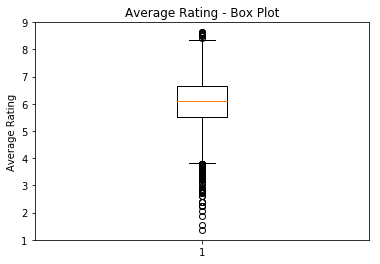

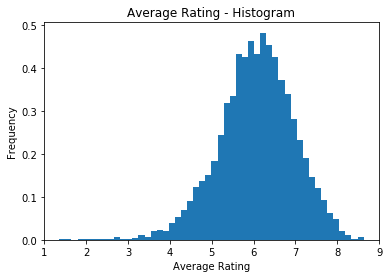

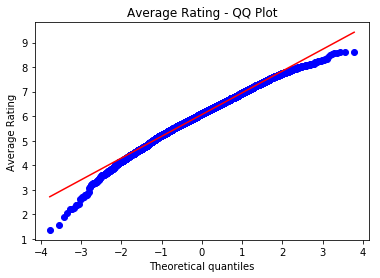

In [11]:
y = np.array(board_game_df_NumRatings_30['average rating'])
x = np.array(board_game_df_NumRatings_30['number of ratings'])

# boxplot
plt.boxplot(y)
plt.title('Average Rating - Box Plot')
plt.ylabel('Average Rating')
plt.show()

# histogram
plt.hist(y, normed=True, bins = 50)
plt.title('Average Rating - Histogram')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()

# qq-plot
stats.probplot(y, dist="norm", plot=pylab)
plt.title('Average Rating - QQ Plot')
plt.ylabel('Average Rating')
pylab.show()

The average rating box plot shows that most of the average ratings users gave the games are between 3.5 and 8. Outside these bounds there are manyoutliers, however, the majority of the games are rated within this range.

The data is fairly normally distributed as can be seen by the histogram and the QQ plot. However, the histogram shows that the data is slightly left skewed. 

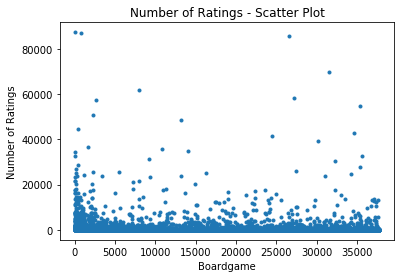

In [12]:
y1 = np.array(board_game_df['number of ratings'])

# scatter plot
plt.plot(y1, marker='.', linestyle='none')
plt.title('Number of Ratings - Scatter Plot')
plt.xlabel('Boardgame')
plt.ylabel('Number of Ratings')
plt.show()

A scatter plot of the number or ratings shows that there are some games that have a huge amount of ratings. However, most games have very few, as can be seen by the clustering at the bottom of the graph

In [13]:
df_sb = pd.DataFrame(y,x)

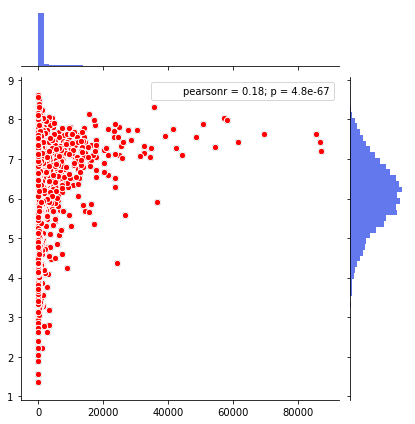

In [14]:
g = sb.jointplot(x=x, y=y, data= df_sb)
g = g.plot_joint(plt.scatter, color="r", s=40, edgecolor="white")
g = g.plot_marginals(sb.distplot, kde=False, color="b")
g = g.annotate(stats.pearsonr)
plt.show()

The joint plot above shows a combination of a Number of Ratings vs. Average Ratings scatter plot, a histogram of the average ratings, and a bar graph of the number of ratings. 

The scatter plot shows the number of ratings vs the average rating of a board game. The plot shows that games with a higher number of ratings tend to recieve a higher average rating. A correlation test between the two variables is seen shown as r = .18 with a p-value of zero. 

The histogram on the right demonstrates that the averge average-rating is around 6. The Bar graph on top illustrates that a vast majority of the board games have few ratings. 

In [15]:
print("Correlation between a boardgame's average rating and its number of ratings:",\
      "{:.3f}".format(board_game_df_NumRatings_30['average rating']\
                      .corr(board_game_df_NumRatings_30['number of ratings'])))

Correlation between a boardgame's average rating and its number of ratings: 0.182


In [16]:
print("Correlation between a boardgame's average rating and its number of ratings:",\
      "{:.3f}".format(board_game_df['average rating']\
                      .corr(board_game_df['number of ratings'])))

Correlation between a boardgame's average rating and its number of ratings: 0.105


The correlation between the two variables when taking into account games with at least 30 ratings shows that the positive correlation of .182.The joint plot above gives a p-value of zero, meaning the correlation coefficient is statistically significant.

The correlation between the two variables without taking into account the number of ratings decreases slightly to .105. The scatter plot from earlier also shows that there is a correlation between the two. 

In [17]:
# Top 20 rated games
board_game_df_NumRatings_30.sort_values('average rating', ascending=False)[0:20].boardgame

6422                            RPGQuest: Greek Mythology
8430                 The Battle of Fontenoy: 11 May, 1745
6146                                             RPGQuest
6048                                     Connection Games
8431                            Prague: The Empty Triumph
3303                  Sports Action Canadian Pro Football
7656    Crusade and Revolution: The Spanish Civil War,...
7776                         Axis Empires: Totaler Krieg!
4113                                    1844: Switzerland
5272                                    Twilight Struggle
6135                       The Penguin Book of Card Games
8058                                    Where Eagles Dare
7156                        RPGQuest: Oriental Adventures
7818                                   Funkenschlag: EnBW
7469                                 D-Day at Omaha Beach
5246                                                 DAK2
7436                                            Case Blue
5256          

These are the games with the highest average rating. 

In [18]:
# Top 20 games witht the most ratings
board_game_df_NumRatings_30.sort_values('number of ratings', ascending=False)[0:20].boardgame

12                       Catan
669                Carcassonne
7539                  Pandemic
8043                  Dominion
4569            Ticket to Ride
7592                  Agricola
2099               Puerto Rico
8510               Small World
1849                Power Grid
5685    Ticket to Ride: Europe
409                   Citadels
8422                     Dixit
7341       Race for the Galaxy
7923                 Stone Age
1379                  Munchkin
5272         Twilight Struggle
5815             Arkham Horror
10                    Bohnanza
47                 Lost Cities
8569            The Resistance
Name: boardgame, dtype: object

These are the games with the highest amount of ratings.

In [21]:
# Looking for attributes that have a correlation of (+/-) .1 or more with average rating 

for col in range(6, 148): 
    if (board_game_df_NumRatings_30_adj['average rating']\
                                      .corr(board_game_df_NumRatings_30_adj[board_game_df_NumRatings_30_adj.columns[col]])) >=.1:
        print("Correlation between a boardgame's average rating and",board_game_df_NumRatings_30_adj.columns[col],'=',\
                "{:.3f}".format(board_game_df_NumRatings_30_adj['average rating']\
                                .corr(board_game_df_NumRatings_30_adj[board_game_df_NumRatings_30_adj.columns[col]])))
            
    elif (board_game_df_NumRatings_30_adj['average rating']\
                                      .corr(board_game_df_NumRatings_30_adj[board_game_df_NumRatings_30_adj.columns[col]])) <=-.1:
        print("Correlation between a boardgame's average rating and",board_game_df_NumRatings_30_adj.columns[col],'=',\
                "{:.3f}".format(board_game_df_NumRatings_30_adj['average rating']\
                                .corr(board_game_df_NumRatings_30_adj[board_game_df_NumRatings_30_adj.columns[col]])))

Correlation between a boardgame's average rating and bg mechanic Route/Network Building = 0.121
Correlation between a boardgame's average rating and bg mechanic Set Collection = -0.102
Correlation between a boardgame's average rating and bg mechanic Campaign / Battle Card Driven = 0.105
Correlation between a boardgame's average rating and bg mechanic Chit-Pull System = 0.100
Correlation between a boardgame's average rating and bg mechanic Hex-and-Counter = 0.278
Correlation between a boardgame's average rating and bg mechanic Area Control / Area Influence = 0.113
Correlation between a boardgame's average rating and bg mechanic Roll / Spin and Move = -0.279
Correlation between a boardgame's average rating and bg mechanic Dice Rolling = 0.159
Correlation between a boardgame's average rating and bg mechanic Simulation = 0.228
Correlation between a boardgame's average rating and bg category World War II = 0.215
Correlation between a boardgame's average rating and bg category Action / Dexte

The list above is all the attributes that have a positive or negative correlation stronger than .1. From the above list it can be seen that there is a high, positive correlation between wargames, World War I, and World War II games. There is a strong, negative correlation between a roll-spin-move game and that game's average rating. Hex-and-counter games, on the other hand, have a strong positive correlation. 

### Hypothesis test: 

ttest for the categorical wargames vs. non-wargames and see if the diff in
avg rating is significant. 


In [23]:
wargame_categ = []
non_wargame_categ = []
for i in range(len(board_game_df_NumRatings_30_adj)):
    if board_game_df_NumRatings_30_adj['bg category Wargame'].iloc[i] == 1.0: 
        wargame_categ.append(board_game_df_NumRatings_30_adj.iloc[i])
    else:
        non_wargame_categ.append(board_game_df_NumRatings_30_adj.iloc[i])    

In [24]:
print('Games in the "wargame" category:',len(wargame_categ))
print('Games NOT in the "wargame" category:',len(non_wargame_categ))

Games in the "wargame" category: 2412
Games NOT in the "wargame" category: 6428


In [25]:
wargame_categ = pd.DataFrame(wargame_categ)
non_wargame_categ = pd.DataFrame(non_wargame_categ)

In [26]:
mean_wargame = np.mean(wargame_categ['average rating'])
mean_non_wargame = np.mean(non_wargame_categ['average rating'])
var_wargame = np.var(wargame_categ['average rating'])
var_non_wargame = np.var(non_wargame_categ['average rating'])

print(mean_wargame)
print(mean_non_wargame)
print(var_wargame)
print(var_non_wargame)

6.601289386401327
5.867285314250167
0.5666827073002869
0.7310205862995794


In [27]:
avg_wargame = wargame_categ['average rating']
avg_non_wargame = non_wargame_categ['average rating'] 

Null-Hypothesis: The mean of the average ratings of board games in the wargame category is equal to that of the non-wargame category 

Alt-Hypothesis: The mean of the two categories are not equal 

alpha= .05

In [28]:
# two-sample t-test with unequal variances
two_sample_ttest = stats.ttest_ind(avg_wargame, avg_non_wargame, equal_var=False)
print('t-statistic:', two_sample_ttest[0])
print('p-value:', two_sample_ttest[1])

t-statistic: 39.30257791643692
p-value: 8.888467411304554e-294


The p-value of the two-sample t-test was far below .05 in the Frequentist Approach. Hence, we reject the null hypothesis that the mean of the mean of the average ratings of board games in the wargame category is equal to that of the non-wargame category. There is evidence to suggest that board games in the wargame category do indeed receive higher average ratings than board games that are not in the wargame category.

# Collaborative Filtering

### Adding the game_ID to the dictionary of username/rating

In [29]:
complete_ratings_list = []
for i in range(len(board_game_df_NumRatings_30)):
    
    # Testing on the first row of rating column
    x_bg = board_game_df_NumRatings_30['ratings'].iloc[i]
    name_bg = board_game_df_NumRatings_30['game ID#'].iloc[i]
    
    # Convert to list of list of dictionaries with json
    x_bg_json = json.loads(x_bg.replace("'", "\""))
    
    # Flatten the 49 pages into one using a list comprehension
    x_bg_ratings = [rating for page in x_bg_json for rating in page]
    
    # Go through x_bg_ratings and add the game_ID using a list comprehension
    complete_ratings_list.append([{'rating': x['rating'],'username': x['username'], 'game_ID': name_bg} for x in x_bg_ratings])
    
    

In [30]:
# Flatten the list of lists to one using a list comprehension
complete_ratings_list = [rating for page in complete_ratings_list for rating in page]

In [32]:
complete_ratings_df = pd.DataFrame(complete_ratings_list)

In [33]:
complete_ratings_df = complete_ratings_df[['username', 'game_ID', 'rating']]

In [34]:
complete_ratings_df.tail(5)

,username,game_ID,rating
6669072,MossGrande,49454,3.0
6669073,crostino,49454,3.0
6669074,wolfzell,49454,2.0
6669075,scatman,49454,2.0
6669076,Nicodemus42,49454,1.0


### Randomly selecting 50,000 rows of complete_ratings_df to test the dataset

In [35]:
# Randomly selecting the 50,000 rows
complete_ratings_10k = complete_ratings_df.sample(n = 50000, random_state = 20)

In [36]:
complete_ratings_10k

,username,game_ID,rating
5137903,holf,28023,7.5
1959756,DigitalCulture,1897,5.0
2668440,tigercats,3488,6.0
3303982,scottieGGGG,8203,7.0
2702311,FizFuz,3685,7.0
...,...,...,...
1760684,Despair,1345,6.0
1352042,dogbert1000,811,8.0
4240596,Ke7in11,16992,7.0
96221,bjhabdas,12,7.0


In [37]:
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate,GridSearchCV

In [38]:
reader = Reader(rating_scale=(1, 10))

In [39]:
# Loads Pandas dataframe
rating_data = Dataset.load_from_df(complete_ratings_10k[['username', 'game_ID', 'rating']], reader)

In [81]:
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering

benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, rating_data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
SVD,1.503394,2.814424,32.666214
BaselineOnly,1.507441,0.393118,0.155054
KNNBaseline,1.518484,44.611629,73.806944
SVDpp,1.527421,5.471261,0.221407
KNNBasic,1.665548,51.948159,33.955794
CoClustering,1.776849,5.688466,0.109350
KNNWithMeans,1.779789,61.708028,40.270545
KNNWithZScore,1.783237,46.179942,15.265567
SlopeOne,1.784331,0.729425,0.121677


In [52]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_epochs': [50, 150, 200], 'lr_all': [.002, 0.005],
              'reg_all': [.01, .025, .05]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(rating_data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.4958252328910397
{'n_epochs': 150, 'lr_all': 0.005, 'reg_all': 0.025}


In [85]:
# We'll use the famous SVD algorithm.
algo = SVD(n_epochs = 150, lr_all = 0.005, reg_all =.025)

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 1.4874


1.4874074264805122

### Memory-based Approach using KNN

In [80]:
# Testing different simulation options
sim_options = {
    "name": ["msd", "cosine", 'pearson'],
    "min_support": [3, 4, 5],
    "user_based": [False, True]}

param_grid = {"sim_options": sim_options}

gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse'], cv=3)
gs.fit(rating_data)

print('Best RMSE:', gs.best_score['rmse'])
print('Best params:', gs.best_params['rmse'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [88]:
# Setting the simulation options
sim_options = {"name": "msd", "min_support": 4, "user_based": False}

algo = KNNWithMeans(sim_options=sim_options)

trainingSet = rating_data.build_full_trainset()
algo.fit(trainingSet)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [94]:
prediction = algo.predict('tigercats', 28023)
prediction.est

7.0600000000000005

In [67]:
complete_ratings_10k

,username,game_ID,rating
5137903,holf,28023,7.5
1959756,DigitalCulture,1897,5.0
2668440,tigercats,3488,6.0
3303982,scottieGGGG,8203,7.0
2702311,FizFuz,3685,7.0
...,...,...,...
1760684,Despair,1345,6.0
1352042,dogbert1000,811,8.0
4240596,Ke7in11,16992,7.0
96221,bjhabdas,12,7.0
